In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-18 13:37:35.180468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 13:37:38.399153: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-18 13:37:38.399330: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

2.11.0


In [2]:
# !git clone https://github.com/EricMartinezIllamola/asl-global.git

In [3]:
# !pip install split-folders 

In [4]:
# import splitfolders
# import os

In [5]:
# path = "asl-global/asl-global"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.7, 0.15, 0.15))

In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
tf.config.experimental.list_physical_devices()

2023-09-18 13:37:42.620717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 13:37:42.635041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 13:37:42.637770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 32 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 4966 images belonging to 34 classes.
Found 1048 images belonging to 34 classes.
Found 1088 images belonging to 34 classes.


In [10]:
#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-18 13:37:43.540871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 13:37:43.542473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 13:37:43.544673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 13:37:43.546551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
##DEFINIMOS EL MODELO
num_classes = 34
epochs = 125

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dense(2048, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [12]:
## EJECUCION DEL MODELO
# with tf.device("/CPU:0"):
# with tf.device("/GPU:0"):
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model-01', verbose=1, save_best_only=True,
                               monitor = 'accuracy', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/125


2023-09-18 13:37:49.397953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-09-18 13:37:51.542560: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f219d7c2580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-18 13:37:51.542614: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-09-18 13:37:51.623608: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


156/156 [==============================] - ETA: 0s - loss: 11.6806 - accuracy: 0.0433
Epoch 1: accuracy improved from -inf to 0.04329, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 22s 102ms/step - loss: 11.6806 - accuracy: 0.0433 - lr: 0.0010
Epoch 2/125
156/156 [==============================] - ETA: 0s - loss: 11.3739 - accuracy: 0.0773
Epoch 2: accuracy improved from 0.04329 to 0.07733, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 97ms/step - loss: 11.3739 - accuracy: 0.0773 - lr: 0.0010
Epoch 3/125
156/156 [==============================] - ETA: 0s - loss: 10.9619 - accuracy: 0.1534
Epoch 3: accuracy improved from 0.07733 to 0.15344, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 94ms/step - loss: 10.9619 - accuracy: 0.1534 - lr: 0.0010
Epoch 4/125
156/156 [==============================] - ETA: 0s - loss: 10.5197 - accuracy: 0.2457
Epoch 4: accuracy improved from 0.15344 to 0.24567, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 97ms/step - loss: 10.5197 - accuracy: 0.2457 - lr: 0.0010
Epoch 5/125
156/156 [==============================] - ETA: 0s - loss: 10.1270 - accuracy: 0.3369
Epoch 5: accuracy improved from 0.24567 to 0.33689, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 96ms/step - loss: 10.1270 - accuracy: 0.3369 - lr: 0.0010
Epoch 6/125
156/156 [==============================] - ETA: 0s - loss: 9.7701 - accuracy: 0.4227
Epoch 6: accuracy improved from 0.33689 to 0.42267, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 99ms/step - loss: 9.7701 - accuracy: 0.4227 - lr: 0.0010
Epoch 7/125
156/156 [==============================] - ETA: 0s - loss: 9.4650 - accuracy: 0.5022
Epoch 7: accuracy improved from 0.42267 to 0.50222, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 95ms/step - loss: 9.4650 - accuracy: 0.5022 - lr: 0.0010
Epoch 8/125
156/156 [==============================] - ETA: 0s - loss: 9.2175 - accuracy: 0.5614
Epoch 8: accuracy improved from 0.50222 to 0.56142, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 99ms/step - loss: 9.2175 - accuracy: 0.5614 - lr: 0.0010
Epoch 9/125
156/156 [==============================] - ETA: 0s - loss: 8.9926 - accuracy: 0.6160
Epoch 9: accuracy improved from 0.56142 to 0.61599, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 94ms/step - loss: 8.9926 - accuracy: 0.6160 - lr: 0.0010
Epoch 10/125
156/156 [==============================] - ETA: 0s - loss: 8.7812 - accuracy: 0.6633
Epoch 10: accuracy improved from 0.61599 to 0.66331, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 99ms/step - loss: 8.7812 - accuracy: 0.6633 - lr: 0.0010
Epoch 11/125
156/156 [==============================] - ETA: 0s - loss: 8.6411 - accuracy: 0.6897
Epoch 11: accuracy improved from 0.66331 to 0.68969, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 96ms/step - loss: 8.6411 - accuracy: 0.6897 - lr: 0.0010
Epoch 12/125
156/156 [==============================] - ETA: 0s - loss: 8.4807 - accuracy: 0.7324
Epoch 12: accuracy improved from 0.68969 to 0.73238, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 97ms/step - loss: 8.4807 - accuracy: 0.7324 - lr: 0.0010
Epoch 13/125
156/156 [==============================] - ETA: 0s - loss: 8.3680 - accuracy: 0.7505
Epoch 13: accuracy improved from 0.73238 to 0.75050, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 96ms/step - loss: 8.3680 - accuracy: 0.7505 - lr: 0.0010
Epoch 14/125
155/156 [============================>.] - ETA: 0s - loss: 8.2926 - accuracy: 0.7532
Epoch 14: accuracy improved from 0.75050 to 0.75352, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 94ms/step - loss: 8.2918 - accuracy: 0.7535 - lr: 0.0010
Epoch 15/125
156/156 [==============================] - ETA: 0s - loss: 8.1743 - accuracy: 0.7825
Epoch 15: accuracy improved from 0.75352 to 0.78252, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 97ms/step - loss: 8.1743 - accuracy: 0.7825 - lr: 0.0010
Epoch 16/125
156/156 [==============================] - ETA: 0s - loss: 8.0828 - accuracy: 0.7936
Epoch 16: accuracy improved from 0.78252 to 0.79360, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 95ms/step - loss: 8.0828 - accuracy: 0.7936 - lr: 0.0010
Epoch 17/125
156/156 [==============================] - ETA: 0s - loss: 7.9759 - accuracy: 0.8091
Epoch 17: accuracy improved from 0.79360 to 0.80910, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 98ms/step - loss: 7.9759 - accuracy: 0.8091 - lr: 0.0010
Epoch 18/125
156/156 [==============================] - ETA: 0s - loss: 7.9182 - accuracy: 0.8214
Epoch 18: accuracy improved from 0.80910 to 0.82139, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 96ms/step - loss: 7.9182 - accuracy: 0.8214 - lr: 0.0010
Epoch 19/125
156/156 [==============================] - ETA: 0s - loss: 7.8510 - accuracy: 0.8230
Epoch 19: accuracy improved from 0.82139 to 0.82300, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 97ms/step - loss: 7.8510 - accuracy: 0.8230 - lr: 0.0010
Epoch 20/125
156/156 [==============================] - ETA: 0s - loss: 7.7745 - accuracy: 0.8343
Epoch 20: accuracy improved from 0.82300 to 0.83427, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 96ms/step - loss: 7.7745 - accuracy: 0.8343 - lr: 0.0010
Epoch 21/125
156/156 [==============================] - ETA: 0s - loss: 7.7117 - accuracy: 0.8411
Epoch 21: accuracy improved from 0.83427 to 0.84112, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 16s 100ms/step - loss: 7.7117 - accuracy: 0.8411 - lr: 0.0010
Epoch 22/125
156/156 [==============================] - ETA: 0s - loss: 7.6405 - accuracy: 0.8498
Epoch 22: accuracy improved from 0.84112 to 0.84978, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 95ms/step - loss: 7.6405 - accuracy: 0.8498 - lr: 0.0010
Epoch 23/125
156/156 [==============================] - ETA: 0s - loss: 7.5726 - accuracy: 0.8540
Epoch 23: accuracy improved from 0.84978 to 0.85401, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 98ms/step - loss: 7.5726 - accuracy: 0.8540 - lr: 0.0010
Epoch 24/125
156/156 [==============================] - ETA: 0s - loss: 7.5233 - accuracy: 0.8570
Epoch 24: accuracy improved from 0.85401 to 0.85703, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 97ms/step - loss: 7.5233 - accuracy: 0.8570 - lr: 0.0010
Epoch 25/125
156/156 [==============================] - ETA: 0s - loss: 7.4583 - accuracy: 0.8661
Epoch 25: accuracy improved from 0.85703 to 0.86609, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 95ms/step - loss: 7.4583 - accuracy: 0.8661 - lr: 0.0010
Epoch 26/125
156/156 [==============================] - ETA: 0s - loss: 7.4043 - accuracy: 0.8649
Epoch 26: accuracy did not improve from 0.86609
156/156 [==============================] - 10s 64ms/step - loss: 7.4043 - accuracy: 0.8649 - lr: 0.0010
Epoch 27/125
156/156 [==============================] - ETA: 0s - loss: 7.3417 - accuracy: 0.8693
Epoch 27: accuracy improved from 0.86609 to 0.86931, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 97ms/step - loss: 7.3417 - accuracy: 0.8693 - lr: 0.0010
Epoch 28/125
156/156 [==============================] - ETA: 0s - loss: 7.2867 - accuracy: 0.8784
Epoch 28: accuracy improved from 0.86931 to 0.87837, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 94ms/step - loss: 7.2867 - accuracy: 0.8784 - lr: 0.0010
Epoch 29/125
156/156 [==============================] - ETA: 0s - loss: 7.2003 - accuracy: 0.8864
Epoch 29: accuracy improved from 0.87837 to 0.88643, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 98ms/step - loss: 7.2003 - accuracy: 0.8864 - lr: 0.0010
Epoch 30/125
156/156 [==============================] - ETA: 0s - loss: 7.1753 - accuracy: 0.8826
Epoch 30: accuracy did not improve from 0.88643
156/156 [==============================] - 10s 63ms/step - loss: 7.1753 - accuracy: 0.8826 - lr: 0.0010
Epoch 31/125
156/156 [==============================] - ETA: 0s - loss: 7.0990 - accuracy: 0.8941
Epoch 31: accuracy improved from 0.88643 to 0.89408, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 97ms/step - loss: 7.0990 - accuracy: 0.8941 - lr: 0.0010
Epoch 32/125
156/156 [==============================] - ETA: 0s - loss: 7.0674 - accuracy: 0.8921
Epoch 32: accuracy did not improve from 0.89408
156/156 [==============================] - 10s 64ms/step - loss: 7.0674 - accuracy: 0.8921 - lr: 0.0010
Epoch 33/125
156/156 [==============================] - ETA: 0s - loss: 7.0110 - accuracy: 0.8953
Epoch 33: accuracy improved from 0.89408 to 0.89529, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 99ms/step - loss: 7.0110 - accuracy: 0.8953 - lr: 0.0010
Epoch 34/125
156/156 [==============================] - ETA: 0s - loss: 6.9566 - accuracy: 0.9021
Epoch 34: accuracy improved from 0.89529 to 0.90213, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 96ms/step - loss: 6.9566 - accuracy: 0.9021 - lr: 0.0010
Epoch 35/125
156/156 [==============================] - ETA: 0s - loss: 6.9050 - accuracy: 0.9060
Epoch 35: accuracy improved from 0.90213 to 0.90596, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 98ms/step - loss: 6.9050 - accuracy: 0.9060 - lr: 0.0010
Epoch 36/125
156/156 [==============================] - ETA: 0s - loss: 6.8487 - accuracy: 0.9070
Epoch 36: accuracy improved from 0.90596 to 0.90697, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 96ms/step - loss: 6.8487 - accuracy: 0.9070 - lr: 0.0010
Epoch 37/125
156/156 [==============================] - ETA: 0s - loss: 6.8055 - accuracy: 0.9112
Epoch 37: accuracy improved from 0.90697 to 0.91120, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 16s 99ms/step - loss: 6.8055 - accuracy: 0.9112 - lr: 0.0010
Epoch 38/125
156/156 [==============================] - ETA: 0s - loss: 6.7741 - accuracy: 0.9076
Epoch 38: accuracy did not improve from 0.91120
156/156 [==============================] - 10s 65ms/step - loss: 6.7741 - accuracy: 0.9076 - lr: 0.0010
Epoch 39/125
156/156 [==============================] - ETA: 0s - loss: 6.7314 - accuracy: 0.9128
Epoch 39: accuracy improved from 0.91120 to 0.91281, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 97ms/step - loss: 6.7314 - accuracy: 0.9128 - lr: 0.0010
Epoch 40/125
156/156 [==============================] - ETA: 0s - loss: 6.6832 - accuracy: 0.9108
Epoch 40: accuracy did not improve from 0.91281
156/156 [==============================] - 10s 64ms/step - loss: 6.6832 - accuracy: 0.9108 - lr: 0.0010
Epoch 41/125
156/156 [==============================] - ETA: 0s - loss: 6.6382 - accuracy: 0.9120
Epoch 41: accuracy did not improve from 0.91281
156/156 [==============================] - 10s 63ms/step - loss: 6.6382 - accuracy: 0.9120 - lr: 0.0010
Epoch 42/125
156/156 [==============================] - ETA: 0s - loss: 6.5871 - accuracy: 0.9150
Epoch 42: accuracy improved from 0.91281 to 0.91502, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 95ms/step - loss: 6.5871 - accuracy: 0.9150 - lr: 0.0010
Epoch 43/125
156/156 [==============================] - ETA: 0s - loss: 6.5388 - accuracy: 0.9140
Epoch 43: accuracy did not improve from 0.91502
156/156 [==============================] - 10s 65ms/step - loss: 6.5388 - accuracy: 0.9140 - lr: 0.0010
Epoch 44/125
156/156 [==============================] - ETA: 0s - loss: 6.4958 - accuracy: 0.9221
Epoch 44: accuracy improved from 0.91502 to 0.92207, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 97ms/step - loss: 6.4958 - accuracy: 0.9221 - lr: 0.0010
Epoch 45/125
156/156 [==============================] - ETA: 0s - loss: 6.4447 - accuracy: 0.9247
Epoch 45: accuracy improved from 0.92207 to 0.92469, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 95ms/step - loss: 6.4447 - accuracy: 0.9247 - lr: 0.0010
Epoch 46/125
156/156 [==============================] - ETA: 0s - loss: 6.3984 - accuracy: 0.9263
Epoch 46: accuracy improved from 0.92469 to 0.92630, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 97ms/step - loss: 6.3984 - accuracy: 0.9263 - lr: 0.0010
Epoch 47/125
156/156 [==============================] - ETA: 0s - loss: 6.3674 - accuracy: 0.9245
Epoch 47: accuracy did not improve from 0.92630
156/156 [==============================] - 10s 65ms/step - loss: 6.3674 - accuracy: 0.9245 - lr: 0.0010
Epoch 48/125
156/156 [==============================] - ETA: 0s - loss: 6.3289 - accuracy: 0.9237
Epoch 48: accuracy did not improve from 0.92630
156/156 [==============================] - 10s 65ms/step - loss: 6.3289 - accuracy: 0.9237 - lr: 0.0010
Epoch 49/125
156/156 [==============================] - ETA: 0s - loss: 6.2811 - accuracy: 0.9307
Epoch 49: accuracy improved from 0.92630 to 0.93073, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 95ms/step - loss: 6.2811 - accuracy: 0.9307 - lr: 0.0010
Epoch 50/125
156/156 [==============================] - ETA: 0s - loss: 6.2481 - accuracy: 0.9297
Epoch 50: accuracy did not improve from 0.93073
156/156 [==============================] - 10s 63ms/step - loss: 6.2481 - accuracy: 0.9297 - lr: 0.0010
Epoch 51/125
156/156 [==============================] - ETA: 0s - loss: 6.1893 - accuracy: 0.9352
Epoch 51: accuracy improved from 0.93073 to 0.93516, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 96ms/step - loss: 6.1893 - accuracy: 0.9352 - lr: 0.0010
Epoch 52/125
156/156 [==============================] - ETA: 0s - loss: 6.1620 - accuracy: 0.9279
Epoch 52: accuracy did not improve from 0.93516
156/156 [==============================] - 10s 64ms/step - loss: 6.1620 - accuracy: 0.9279 - lr: 0.0010
Epoch 53/125
156/156 [==============================] - ETA: 0s - loss: 6.0952 - accuracy: 0.9396
Epoch 53: accuracy improved from 0.93516 to 0.93959, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 14s 93ms/step - loss: 6.0952 - accuracy: 0.9396 - lr: 0.0010
Epoch 54/125
156/156 [==============================] - ETA: 0s - loss: 6.0886 - accuracy: 0.9301
Epoch 54: accuracy did not improve from 0.93959
156/156 [==============================] - 10s 63ms/step - loss: 6.0886 - accuracy: 0.9301 - lr: 0.0010
Epoch 55/125
156/156 [==============================] - ETA: 0s - loss: 6.0356 - accuracy: 0.9380
Epoch 55: accuracy did not improve from 0.93959
156/156 [==============================] - 10s 64ms/step - loss: 6.0356 - accuracy: 0.9380 - lr: 0.0010
Epoch 56/125
156/156 [==============================] - ETA: 0s - loss: 6.0052 - accuracy: 0.9356
Epoch 56: accuracy did not improve from 0.93959
156/156 [==============================] - 10s 64ms/step - loss: 6.0052 - accuracy: 0.9356 - lr: 0.0010
Epoch 57/125
156/156 [==============================] - ETA: 0s - loss: 5.9556 - accuracy: 0.9380
Epoch 57: accuracy did not improve from 0.93959


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 98ms/step - loss: 5.8721 - accuracy: 0.9422 - lr: 0.0010
Epoch 60/125
156/156 [==============================] - ETA: 0s - loss: 5.8554 - accuracy: 0.9356
Epoch 60: accuracy did not improve from 0.94221
156/156 [==============================] - 10s 64ms/step - loss: 5.8554 - accuracy: 0.9356 - lr: 0.0010
Epoch 61/125
156/156 [==============================] - ETA: 0s - loss: 5.7933 - accuracy: 0.9450
Epoch 61: accuracy improved from 0.94221 to 0.94503, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 98ms/step - loss: 5.7933 - accuracy: 0.9450 - lr: 0.0010
Epoch 62/125
156/156 [==============================] - ETA: 0s - loss: 5.7561 - accuracy: 0.9474
Epoch 62: accuracy improved from 0.94503 to 0.94744, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 94ms/step - loss: 5.7561 - accuracy: 0.9474 - lr: 0.0010
Epoch 63/125
156/156 [==============================] - ETA: 0s - loss: 5.7324 - accuracy: 0.9408
Epoch 63: accuracy did not improve from 0.94744
156/156 [==============================] - 10s 64ms/step - loss: 5.7324 - accuracy: 0.9408 - lr: 0.0010
Epoch 64/125
156/156 [==============================] - ETA: 0s - loss: 5.6875 - accuracy: 0.9497
Epoch 64: accuracy improved from 0.94744 to 0.94966, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 98ms/step - loss: 5.6875 - accuracy: 0.9497 - lr: 0.0010
Epoch 65/125
156/156 [==============================] - ETA: 0s - loss: 5.6465 - accuracy: 0.9503
Epoch 65: accuracy improved from 0.94966 to 0.95026, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 95ms/step - loss: 5.6465 - accuracy: 0.9503 - lr: 0.0010
Epoch 66/125
156/156 [==============================] - ETA: 0s - loss: 5.6246 - accuracy: 0.9452
Epoch 66: accuracy did not improve from 0.95026
156/156 [==============================] - 10s 65ms/step - loss: 5.6246 - accuracy: 0.9452 - lr: 0.0010
Epoch 67/125
156/156 [==============================] - ETA: 0s - loss: 5.5945 - accuracy: 0.9446
Epoch 67: accuracy did not improve from 0.95026
156/156 [==============================] - 10s 65ms/step - loss: 5.5945 - accuracy: 0.9446 - lr: 0.0010
Epoch 68/125
156/156 [==============================] - ETA: 0s - loss: 5.5393 - accuracy: 0.9509
Epoch 68: accuracy improved from 0.95026 to 0.95087, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 97ms/step - loss: 5.5393 - accuracy: 0.9509 - lr: 0.0010
Epoch 69/125
156/156 [==============================] - ETA: 0s - loss: 5.5226 - accuracy: 0.9444
Epoch 69: accuracy did not improve from 0.95087
156/156 [==============================] - 10s 65ms/step - loss: 5.5226 - accuracy: 0.9444 - lr: 0.0010
Epoch 70/125
156/156 [==============================] - ETA: 0s - loss: 5.4721 - accuracy: 0.9509
Epoch 70: accuracy did not improve from 0.95087
156/156 [==============================] - 10s 64ms/step - loss: 5.4721 - accuracy: 0.9509 - lr: 0.0010
Epoch 71/125
156/156 [==============================] - ETA: 0s - loss: 5.4362 - accuracy: 0.9499
Epoch 71: accuracy did not improve from 0.95087
156/156 [==============================] - 10s 65ms/step - loss: 5.4362 - accuracy: 0.9499 - lr: 0.0010
Epoch 72/125
156/156 [==============================] - ETA: 0s - loss: 5.4069 - accuracy: 0.9519
Epoch 72: accuracy improved from 0.95087 to 0.95

INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 97ms/step - loss: 5.4069 - accuracy: 0.9519 - lr: 0.0010
Epoch 73/125
156/156 [==============================] - ETA: 0s - loss: 5.3761 - accuracy: 0.9517
Epoch 73: accuracy did not improve from 0.95187
156/156 [==============================] - 10s 65ms/step - loss: 5.3761 - accuracy: 0.9517 - lr: 0.0010
Epoch 74/125
156/156 [==============================] - ETA: 0s - loss: 5.3274 - accuracy: 0.9565
Epoch 74: accuracy improved from 0.95187 to 0.95650, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 97ms/step - loss: 5.3274 - accuracy: 0.9565 - lr: 0.0010
Epoch 75/125
156/156 [==============================] - ETA: 0s - loss: 5.3191 - accuracy: 0.9489
Epoch 75: accuracy did not improve from 0.95650
156/156 [==============================] - 10s 64ms/step - loss: 5.3191 - accuracy: 0.9489 - lr: 0.0010
Epoch 76/125
156/156 [==============================] - ETA: 0s - loss: 5.2571 - accuracy: 0.9569
Epoch 76: accuracy improved from 0.95650 to 0.95691, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 95ms/step - loss: 5.2571 - accuracy: 0.9569 - lr: 0.0010
Epoch 77/125
156/156 [==============================] - ETA: 0s - loss: 5.2273 - accuracy: 0.9587
Epoch 77: accuracy improved from 0.95691 to 0.95872, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 98ms/step - loss: 5.2273 - accuracy: 0.9587 - lr: 0.0010
Epoch 78/125
156/156 [==============================] - ETA: 0s - loss: 5.2037 - accuracy: 0.9549
Epoch 78: accuracy did not improve from 0.95872
156/156 [==============================] - 10s 63ms/step - loss: 5.2037 - accuracy: 0.9549 - lr: 0.0010
Epoch 79/125
156/156 [==============================] - ETA: 0s - loss: 5.1650 - accuracy: 0.9539
Epoch 79: accuracy did not improve from 0.95872
156/156 [==============================] - 10s 63ms/step - loss: 5.1650 - accuracy: 0.9539 - lr: 0.0010
Epoch 80/125
156/156 [==============================] - ETA: 0s - loss: 5.1488 - accuracy: 0.9505
Epoch 80: accuracy did not improve from 0.95872
156/156 [==============================] - 10s 64ms/step - loss: 5.1488 - accuracy: 0.9505 - lr: 0.0010
Epoch 81/125
156/156 [==============================] - ETA: 0s - loss: 5.1039 - accuracy: 0.9561
Epoch 81: accuracy did not improve from 0.95872


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 98ms/step - loss: 5.0585 - accuracy: 0.9619 - lr: 0.0010
Epoch 83/125
156/156 [==============================] - ETA: 0s - loss: 5.0378 - accuracy: 0.9533
Epoch 83: accuracy did not improve from 0.96194
156/156 [==============================] - 10s 63ms/step - loss: 5.0378 - accuracy: 0.9533 - lr: 0.0010
Epoch 84/125
156/156 [==============================] - ETA: 0s - loss: 5.0032 - accuracy: 0.9577
Epoch 84: accuracy did not improve from 0.96194
156/156 [==============================] - 10s 63ms/step - loss: 5.0032 - accuracy: 0.9577 - lr: 0.0010
Epoch 85/125
156/156 [==============================] - ETA: 0s - loss: 4.9713 - accuracy: 0.9601
Epoch 85: accuracy did not improve from 0.96194
156/156 [==============================] - 10s 64ms/step - loss: 4.9713 - accuracy: 0.9601 - lr: 0.0010
Epoch 86/125
156/156 [==============================] - ETA: 0s - loss: 4.9618 - accuracy: 0.9503
Epoch 86: accuracy did not improve from 0.96194


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 96ms/step - loss: 4.7045 - accuracy: 0.9621 - lr: 0.0010
Epoch 95/125
156/156 [==============================] - ETA: 0s - loss: 4.6687 - accuracy: 0.9609
Epoch 95: accuracy did not improve from 0.96214
156/156 [==============================] - 10s 66ms/step - loss: 4.6687 - accuracy: 0.9609 - lr: 0.0010
Epoch 96/125
156/156 [==============================] - ETA: 0s - loss: 4.6496 - accuracy: 0.9585
Epoch 96: accuracy did not improve from 0.96214
156/156 [==============================] - 10s 66ms/step - loss: 4.6496 - accuracy: 0.9585 - lr: 0.0010
Epoch 97/125
156/156 [==============================] - ETA: 0s - loss: 4.6149 - accuracy: 0.9623
Epoch 97: accuracy improved from 0.96214 to 0.96234, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 16s 99ms/step - loss: 4.6149 - accuracy: 0.9623 - lr: 0.0010
Epoch 98/125
156/156 [==============================] - ETA: 0s - loss: 4.5721 - accuracy: 0.9666
Epoch 98: accuracy improved from 0.96234 to 0.96657, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 96ms/step - loss: 4.5721 - accuracy: 0.9666 - lr: 0.0010
Epoch 99/125
156/156 [==============================] - ETA: 0s - loss: 4.5657 - accuracy: 0.9561
Epoch 99: accuracy did not improve from 0.96657
156/156 [==============================] - 10s 64ms/step - loss: 4.5657 - accuracy: 0.9561 - lr: 0.0010
Epoch 100/125
156/156 [==============================] - ETA: 0s - loss: 4.5262 - accuracy: 0.9634
Epoch 100: accuracy did not improve from 0.96657
156/156 [==============================] - 10s 65ms/step - loss: 4.5262 - accuracy: 0.9634 - lr: 0.0010
Epoch 101/125
156/156 [==============================] - ETA: 0s - loss: 4.4976 - accuracy: 0.9617
Epoch 101: accuracy did not improve from 0.96657
156/156 [==============================] - 10s 64ms/step - loss: 4.4976 - accuracy: 0.9617 - lr: 0.0010
Epoch 102/125
156/156 [==============================] - ETA: 0s - loss: 4.4699 - accuracy: 0.9658
Epoch 102: accuracy did not improve from 0.

INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 16s 101ms/step - loss: 4.3875 - accuracy: 0.9676 - lr: 0.0010
Epoch 106/125
156/156 [==============================] - ETA: 0s - loss: 4.3758 - accuracy: 0.9589
Epoch 106: accuracy did not improve from 0.96758
156/156 [==============================] - 10s 66ms/step - loss: 4.3758 - accuracy: 0.9589 - lr: 0.0010
Epoch 107/125
156/156 [==============================] - ETA: 0s - loss: 4.3285 - accuracy: 0.9656
Epoch 107: accuracy did not improve from 0.96758
156/156 [==============================] - 10s 64ms/step - loss: 4.3285 - accuracy: 0.9656 - lr: 0.0010
Epoch 108/125
156/156 [==============================] - ETA: 0s - loss: 4.3154 - accuracy: 0.9623
Epoch 108: accuracy did not improve from 0.96758
156/156 [==============================] - 10s 65ms/step - loss: 4.3154 - accuracy: 0.9623 - lr: 0.0010
Epoch 109/125
156/156 [==============================] - ETA: 0s - loss: 4.2702 - accuracy: 0.9716
Epoch 109: accuracy improved from 0.9675

INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 96ms/step - loss: 4.2702 - accuracy: 0.9716 - lr: 0.0010
Epoch 110/125
156/156 [==============================] - ETA: 0s - loss: 4.2454 - accuracy: 0.9710
Epoch 110: accuracy did not improve from 0.97161
156/156 [==============================] - 10s 65ms/step - loss: 4.2454 - accuracy: 0.9710 - lr: 0.0010
Epoch 111/125
156/156 [==============================] - ETA: 0s - loss: 4.2249 - accuracy: 0.9668
Epoch 111: accuracy did not improve from 0.97161
156/156 [==============================] - 10s 63ms/step - loss: 4.2249 - accuracy: 0.9668 - lr: 0.0010
Epoch 112/125
156/156 [==============================] - ETA: 0s - loss: 4.1934 - accuracy: 0.9662
Epoch 112: accuracy did not improve from 0.97161
156/156 [==============================] - 10s 65ms/step - loss: 4.1934 - accuracy: 0.9662 - lr: 0.0010
Epoch 113/125
156/156 [==============================] - ETA: 0s - loss: 4.1674 - accuracy: 0.9700
Epoch 113: accuracy did not improve from 

INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 15s 98ms/step - loss: 3.9374 - accuracy: 0.9720 - lr: 0.0010
Epoch 123/125
156/156 [==============================] - ETA: 0s - loss: 3.9229 - accuracy: 0.9684
Epoch 123: accuracy did not improve from 0.97201
156/156 [==============================] - 11s 68ms/step - loss: 3.9229 - accuracy: 0.9684 - lr: 0.0010
Epoch 124/125
156/156 [==============================] - ETA: 0s - loss: 3.8982 - accuracy: 0.9676
Epoch 124: accuracy did not improve from 0.97201
156/156 [==============================] - 10s 66ms/step - loss: 3.8982 - accuracy: 0.9676 - lr: 0.0010
Epoch 125/125
156/156 [==============================] - ETA: 0s - loss: 3.8656 - accuracy: 0.9724
Epoch 125: accuracy improved from 0.97201 to 0.97241, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


156/156 [==============================] - 20s 130ms/step - loss: 3.8656 - accuracy: 0.9724 - lr: 0.0010


In [13]:
preds_test = model.predict(test_generator)

34/34 [==============================] - 4s 113ms/step


In [14]:
evaluate_test = model.evaluate(test_generator)

34/34 [==============================] - 4s 111ms/step - loss: 4.0087 - accuracy: 0.9393


In [15]:
evaluate_test

[4.008734226226807, 0.939338207244873]

In [16]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([16,  0,  0, ..., 33, 33, 33])

In [17]:
y_real_test = test_generator.classes
y_real_test

array([ 0,  0,  0, ..., 33, 33, 33], dtype=int32)

In [18]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.9384191176470589

In [19]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[31,  0,  0, ...,  0,  0,  0],
       [ 0, 31,  0, ...,  0,  0,  0],
       [ 0,  0, 32, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 30,  0,  0],
       [ 0,  0,  0, ...,  0, 28,  1],
       [ 0,  0,  0, ...,  2,  0, 30]])

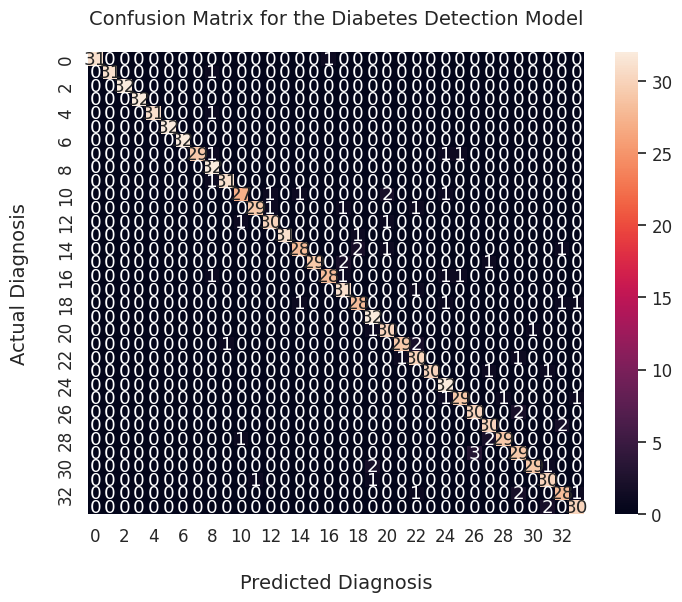

In [20]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [21]:
preds_val = model.predict(valid_generator)

33/33 [==============================] - 3s 83ms/step


In [22]:
evaluate_val = model.evaluate(valid_generator)

33/33 [==============================] - 2s 65ms/step - loss: 3.9284 - accuracy: 0.9609


In [23]:
evaluate_val

[3.9283852577209473, 0.9608778357505798]

In [24]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([ 0,  0,  0, ..., 33, 33, 33])

In [25]:
y_real_val = valid_generator.classes
y_real_val

array([ 0,  0,  0, ..., 33, 33, 33], dtype=int32)

In [26]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9580152671755725

In [27]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[30,  0,  0, ...,  0,  0,  0],
       [ 0, 30,  0, ...,  0,  0,  0],
       [ 0,  0, 29, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 30,  0,  1],
       [ 0,  0,  0, ...,  0, 29,  0],
       [ 0,  0,  0, ...,  0,  0, 31]])

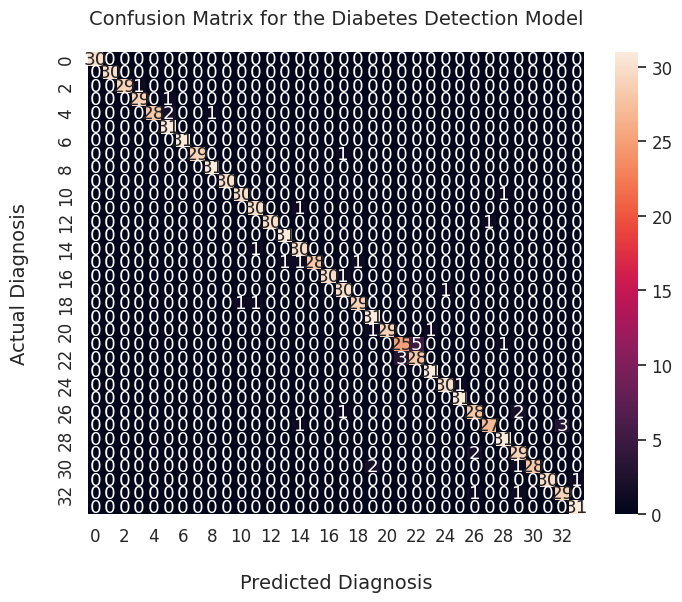

In [28]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()